In [1]:
import json 
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"


In [2]:
import pandas as pd

data = pd.read_csv('../sources/Q1_names.csv', sep=';')
q1_data = data[data["SJR Quartile"] == "Q1"]


q1_names = q1_data["Title"].tolist()
sjr_dict = dict(zip(q1_data["Title"], q1_data["SJR"]))


FileNotFoundError: [Errno 2] No such file or directory: '../sources/Q1_names.csv'

In [ ]:
import re
def normalize(text):
    text = text.lower()                 
    text = text.replace("&", "and")     
    text = text.replace(",", "")     
    return text

for i, name in enumerate(q1_names):
    if name == "International Journal of Neuropsychopharmacology":
        q1_names[i] = "The International Journal of Neuropsychopharmacology"
        sjr_dict[q1_names[i]] = sjr_dict.pop(name)
    elif name == "Chinese Medicine (United Kingdom)":
        q1_names[i] = "Chinese Medicine"
        sjr_dict[q1_names[i]] = sjr_dict.pop(name)
    elif name == "Biomolecules and Therapeutics": 
        q1_names[i] = "Biomolecules & Therapeutics"
        sjr_dict[q1_names[i]] = sjr_dict.pop(name)

In [3]:
bjp = (
    alex.Sources()["s55107261"] # ID OpenAlex of the BJP
)

with open("../sources/bjp.json", "w") as f:
    json.dump(bjp, f, indent = 4)

bjp_counts_by_year = bjp["counts_by_year"]
with open("../sources/bjp_counts_by_year.json", "w") as f:
    json.dump(bjp_counts_by_year, f, indent = 4)    
df_bjp= pd.read_json("..sources/bjp_counts_by_year.json")

q1_journals_info = []

for journal in q1_names:
    source = alex.Sources().search(f'"{journal}"')
    found = False
    for page in range(1, 10):  
        results = source.get(page=page, per_page=200)
        if not results:
            break
        for r in results:
            if normalize(r["display_name"]) == normalize(journal):
                r["SJR"] = sjr_dict[journal] 
                q1_journals_info.append(r)
                found = True
                break
        if found:
            break
    if not found:
        print(f"{journal} not found")
    else:
        print(f"{journal} found")

FileNotFoundError: [Errno 2] No such file or directory: '../sources/bjp.json'

In [ ]:
with open("../sources/bjp.json", "w") as f:
    json.dump(bjp, f, indent = 4)

with open("../sources/q1_journals.json", "w", encoding="utf-8") as f:
    json.dump(q1_journals_info, f, ensure_ascii=False, indent=4)


df_q1 = pd.DataFrame(q1_journals_info)
df_q1_csv = df_q1.to_csv("../sources/q1_journals.csv", index=False, sep=';')
print(df_q1.head())


df_q1["SJR"] = df_q1["SJR"].str.replace(',', '.')
df_q1["SJR"] = pd.to_numeric(df_q1["SJR"], errors='coerce')

print(df_q1.head())

df_q1_sjr = df_q1.head(20)[["display_name", "SJR"]]




                                 id     issn_l                    issn  \
0   https://openalex.org/S186543748  1474-1776  [1474-1776, 1474-1784]   
1   https://openalex.org/S161680845  0031-6997  [0031-6997, 1521-0081]   
2    https://openalex.org/S47159833  1368-7646  [1368-7646, 1532-2084]   
3  https://openalex.org/S2754803477  2051-1426             [2051-1426]   
4    https://openalex.org/S51596929  1525-0016  [1525-0016, 1525-0024]   

                          display_name                 host_organization  \
0        Nature Reviews Drug Discovery  https://openalex.org/P4310319908   
1              Pharmacological Reviews  https://openalex.org/P4310316283   
2              Drug Resistance Updates  https://openalex.org/P4310320990   
3  Journal for ImmunoTherapy of Cancer  https://openalex.org/P4310319945   
4                    Molecular Therapy  https://openalex.org/P4310320990   

                              host_organization_name  \
0                                    Sprin

C:\Users\noahr\AppData\Local\Temp\ipykernel_22476\932038624.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SJR", y="display_name", data=df_q1_sjr, palette="viridis")


<Figure size 640x480 with 0 Axes>

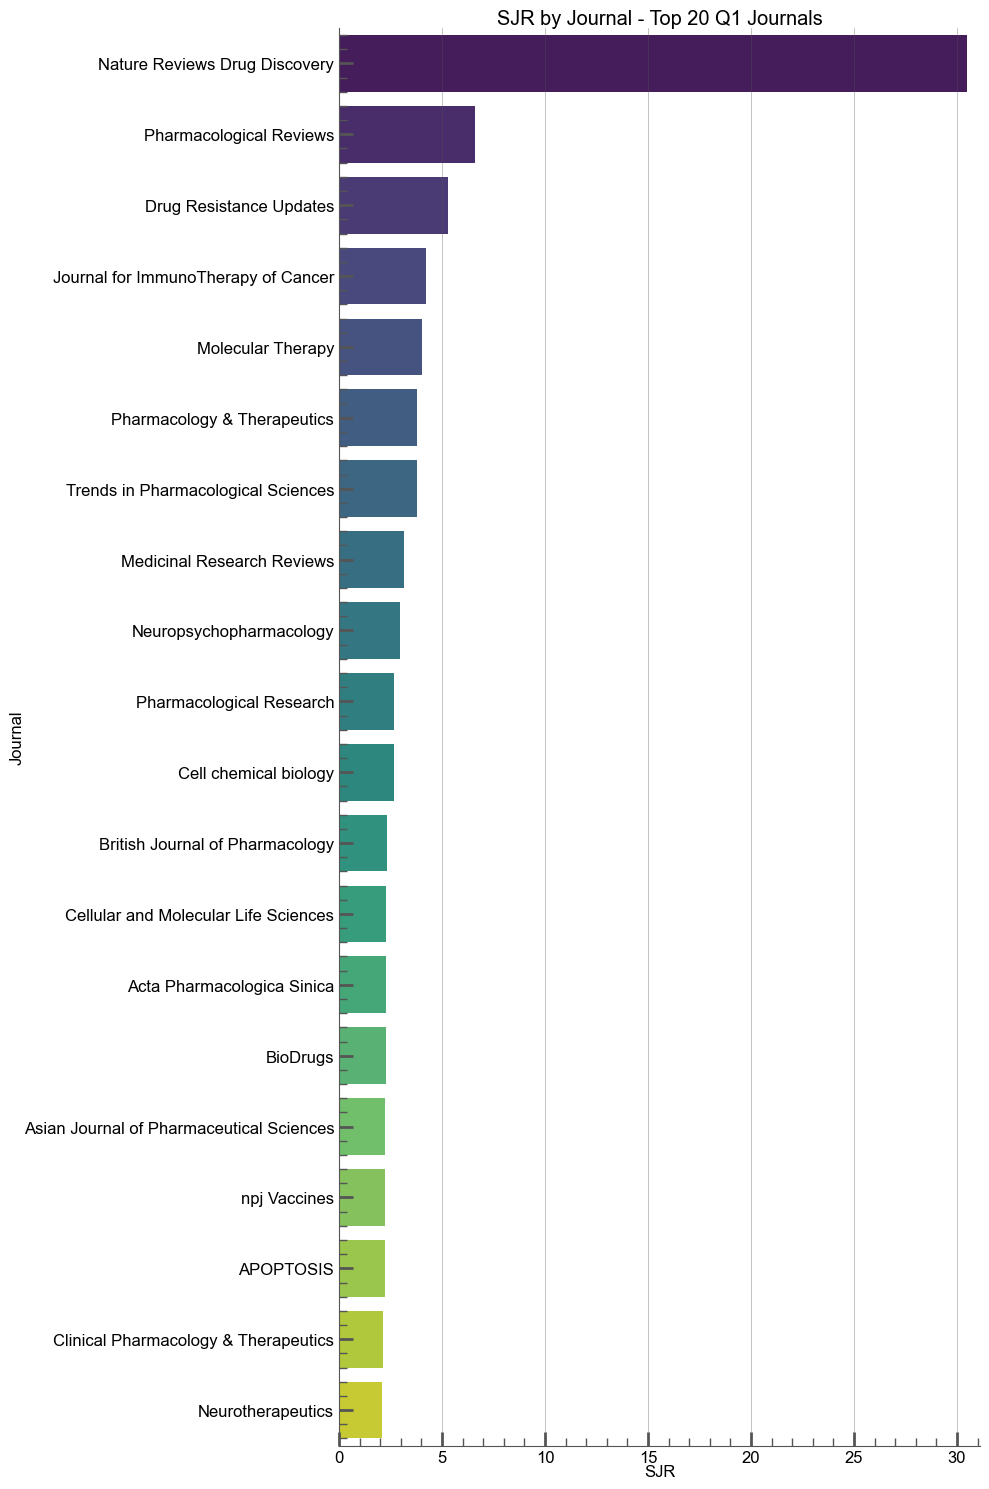

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,15))
    sns.barplot(x="SJR", y="display_name", data=df_q1_sjr, palette="viridis")
    plt.xlabel("SJR")
    plt.ylabel("Journal")
    plt.title("SJR by Journal - Top 20 Q1 Journals")
    plt.tight_layout()
    plt.show()


In [ ]:
data = []

pager = alex.Works().filter(locations={"source": {"id": "s55107261"}}).paginate(per_page = 200, n_max = None)
for page in pager:
    for work in page:
        authors = []
        institutions = []
        countries = []
        for i in work.get("authorships"):
            authors.append((i.get("author")).get("id"))

            for j in i.get("institutions"):
                institutions.append([j.get("display_name"), j.get("id")])

            for j in i.get("countries"):
                countries.append(j)

        new = {
            "title": work.get("title"),
            "year": work.get("publication_year"),
            "cited_by_count": work.get("cited_by_count"),          
            "countries_distinct_count": work.get("countries_distinct_count"),
            "institutions_distinct_count": work.get("institutions_distinct_count"),
            "citation_normalized_percentile": work.get("citation_normalized_percentile"),
            "primary_topic": work.get("primary_topic"), 
            "keywords": work.get("keywords"), 
            "concepts": work.get("concepts"),
            "referenced_works_count": work.get("referenced_works_count"),
            "referenced_works": work.get("referenced_works"), 
            "abstract": work["abstract"],
            "abstract_inverted_index": work.get("abstract_inverted_index"),
            "journal":work.get("primary_location").get("source").get("display_name")
        }
        for i in range(1, len(authors) + 1):
            new[f"author_{i}"] = authors[i - 1]
        for i in range(1, len(institutions) + 1):
            new[f"institution_{i}"] = institutions[i - 1]
        for i in range(1, len(countries) + 1):
            new[f"country_{i}"] = countries[i - 1]
        for i in work.get("counts_by_year"):
            new[f"cited_by_count_{i.get("year")}"] = i.get("cited_by_count")
        if work.get("primary_topic") != None:
            new["primary_topic"] =  (work.get("primary_topic")).get("display_name"),
            new["primary_subfield"] =  ((work.get("primary_topic")).get("subfield")).get("display_name"),
            new["primary_field"] =  ((work.get("primary_topic")).get("field")).get("display_name"),
            new["primary_domain"] =  ((work.get("primary_topic")).get("domain")).get("display_name"),

        count = 1
        for i in work.get("keywords"):
            new[f"keyword_{count}"] = i.get("display_name")
            count += 1

            
        data.append(new)
data = pd.DataFrame(data)

In [ ]:
data.to_csv("data/works/works_bjp.csv", index = False)

In [ ]:

from pyalex import Works
def fetch_works_for_journal(source_id):
    data_local = []
    pager = Works().filter(locations={"source": {"id": source_id}}).paginate(per_page=200, n_max=None)

    for page in pager:
        for work in page:
            authors = [(i.get("author")).get("id") for i in work.get("authorships", [])]

            institutions = []
            countries = []
            for i in work.get("authorships", []):
                institutions.extend([[j.get("display_name"), j.get("id")] for j in i.get("institutions", [])])
                countries.extend(i.get("countries", []))

            new = {
                "title": work.get("title"),
                "year": work.get("publication_year"),
                "cited_by_count": work.get("cited_by_count"),
                "countries_distinct_count": work.get("countries_distinct_count"),
                "institutions_distinct_count": work.get("institutions_distinct_count"),
                "citation_normalized_percentile": work.get("citation_normalized_percentile"),
                "primary_topic": work.get("primary_topic"),
                "keywords": work.get("keywords"),
                "concepts": work.get("concepts"),
                "referenced_works_count": work.get("referenced_works_count"),
                "referenced_works": work.get("referenced_works"),
                "abstract": work.get("abstract"),
                "abstract_inverted_index": work.get("abstract_inverted_index"),
                "journal": work.get("primary_location", {}).get("source", {}).get("display_name"),
            }

            for i, author in enumerate(authors, 1):
                new[f"author_{i}"] = author
            for i, inst in enumerate(institutions, 1):
                new[f"institution_{i}"] = inst
            for i, country in enumerate(countries, 1):
                new[f"country_{i}"] = country
            for i in work.get("counts_by_year", []):
                new[f"cited_by_count_{i.get('year')}"] = i.get("cited_by_count")

            if work.get("primary_topic") is not None:
                new["primary_topic"] = work["primary_topic"].get("display_name")
                new["primary_subfield"] = work["primary_topic"]["subfield"].get("display_name")
                new["primary_field"] = work["primary_topic"]["field"].get("display_name")
                new["primary_domain"] = work["primary_topic"]["domain"].get("display_name")

            for idx, kw in enumerate(work.get("keywords", []), 1):
                new[f"keyword_{idx}"] = kw.get("display_name")

            data_local.append(new)

    return data_local


In [ ]:
top_journals = df_q1[["display_name", "SJR", "cited_by_count", "host_organization", "works_count", "id"]].sort_values(by = "SJR", ascending = False).reset_index()

works_count = 0
for source in top_journals["id"]:
    result = alex.Works().filter(locations={"source": {"id": source}}).get()
    works_count += result.meta["count"]
print(f"Total works in top journals: {works_count}")

Total works in top journals: 712454


In [ ]:

import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

start_time = time.time()
data = []

journal_ids = top_journals["id"].to_list()

with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(fetch_works_for_journal, jid): jid for jid in journal_ids}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Extraction works"):
        data.extend(future.result())

elapsed = time.time() - start_time



Extraction works: 100%|██████████| 81/81 [59:54<00:00, 44.38s/it]   


Extraction terminée : 712466 works récupérés en 59.9 min


In [ ]:
data_chunks = [] 
for i in range(0, len(data), 10_000):
    data_chunks.append(data[i:i + 10_000])
data = pd.DataFrame()
for i in range(len(data_chunks)):
    data_chunks[i] = pd.DataFrame(data_chunks[i])
    
df = pd.concat(data_chunks)
print(len(df))
df.to_csv("data/works/works_q1.csv", index = False)

712466
